# Introduction

The aim of this notebook is to introduce the driver class *PyVisa_Rigol_DP832A* utilizing the programmable DC power supply **Rigol DP832A** in my lab.

Sources (small selection):

- Basic functions for controlling test equipment with PyVisa: [https://github.com/freq0ut/Python-PyVisa](https://github.com/freq0ut/Python-PyVisa)
- Controlling a Rigol DP832 using PyVISA: [https://fixturfab.com/articles/controlling-rigol-dp832-using-pyvisa/](https://fixturfab.com/articles/controlling-rigol-dp832-using-pyvisa/)
- Controlling Rigol Dp832 with python: [https://juluribk.com/controlling-rigol-dp832-with-python.html](https://juluribk.com/controlling-rigol-dp832-with-python.html)
- Automating Test-Equipment with Python: [https://core-electronics.com.au/tutorials/automating-test-equipment-with-python.html](https://core-electronics.com.au/tutorials/automating-test-equipment-with-python.html)
- [DP800 Programming Manual, 2021-07-01](https://int.rigol.com/Images/DP800_ProgrammingGuide_EN_tcm7-3044.pdf)

## Installation of required Python libraries

In this application [PyVisa](https://pypi.org/project/PyVISA/) and [PyVISA-py](https://github.com/pyvisa/pyvisa-py) are used to communicate with the Rigol DP832A via LAN (TCP/IP) interface and SCPI commands. The communication over the USB device port does not work for me at the moment.

On Raspberry Pi both Python packages have to be installed first either via *pip* command or using *conda*.

Without conda, the installation is sensibly carried out in a Python *virtualenv* environment:
```
$ source ~/jupyter-env/bin/activate
$ pip install pyvisa pyvisa-py
```

## Load globally used libraries and set plot parameters

In [1]:
import time
import os

import pandas as pd

import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
%matplotlib inline

# FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. 
# The converter was registered by pandas on import. 
# Future versions of pandas will require you to explicitly register matplotlib converters.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'png') # <== deprecated since IPython 7.23
%config InlineBackend.figure_formats = ['pdf', 'png']

plt.rcParams['savefig.dpi'] = 80
plt.rcParams['savefig.bbox'] = "tight"

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

# Need to install dependent package first via 'apt install cm-super'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

from IPython.display import Image

# Short technical overview of the Rigol DP832A

The Rigol DP832A is a very high quality programmable laboratory power supply with three switchable outputs (+30 V/3 A, +30 V/3 A and +5 V/3 A) and a maximum power output of 195 W.

Following documentation were helpful for further understanding (found [here](https://int.rigol.com/products/DP_detail/DP800)):

- [DP800 User Manual, 2016-06-03](https://int.rigol.com/Images/DP800_UserGuide_EN_tcm7-3049.pdf)
- [DP800 Programming Manual, 2021-07-01](https://int.rigol.com/Images/DP800_ProgrammingGuide_EN_tcm7-3044.pdf)

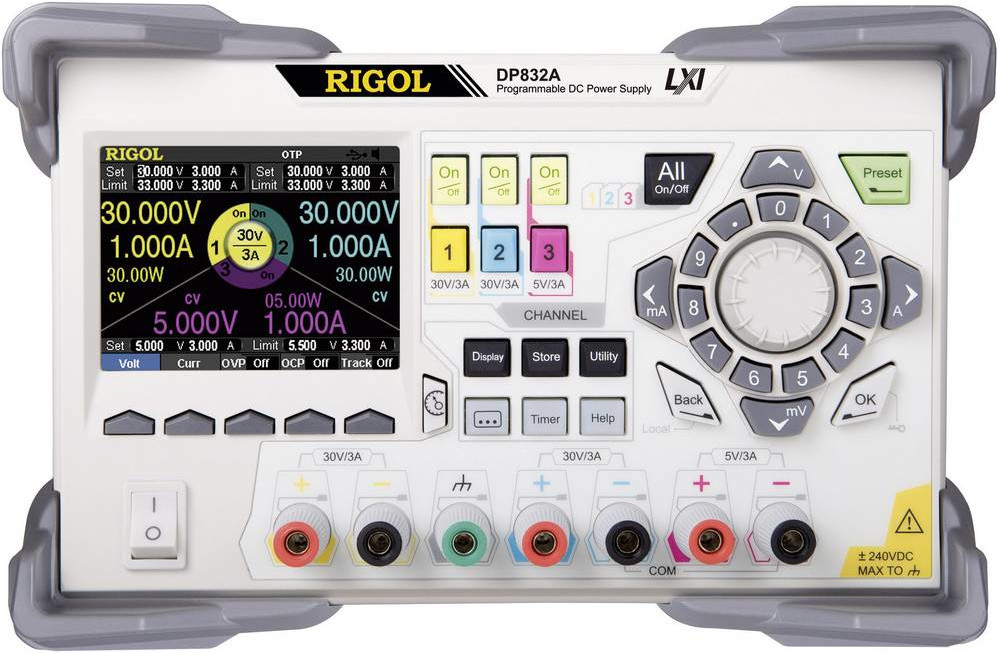

In [2]:
Image('images/rigol-dp832a-front.jpg', height=200)

# Remote control of the Rigol DP832A by SCPI commands

The device can be controlled remotely with SCPI commands through a variety of interfaces. The following interfaces are available:

- USB
- LAN
- GPIB (optional)

Control of the device can be integrated into your own applications, or by using LabView via these interfaces.

In this application [PyVisa](https://pypi.org/project/PyVISA/) and [PyVISA-py](https://github.com/pyvisa/pyvisa-py) are used to communicate with the Rigol DP832A via LAN (TCP/IP) interface and SCPI commands. The communication over the USB device port does not work for me at the moment.

## Using the wrapper class 'PyVisa_Rigol_DP832A' manually

The new wrapper class **PyVisa_Rigol_DP832A** in the python file *PyVisa_Rigol_DP832A_class.py* implements the communication with the Rigol DP832A via LAN interface and SCPI commands using PyVisa and PyVISA-py.

Separate class methods realize the basic control of the power supply, such as setting the current and voltage in the selected channel as well as setting and activating the overvoltage protection (OVP) and overcurrent protection (OCP). In addition, there are methods for measuring the actual values in the selected channel (current, voltage and power).

In [3]:
# import wrapper class PyVisa_Rigol_DP832A from python file PyVisa_Rigol_DP832A_class.py
from PyVisa_Rigol_DP832A_class import PyVisa_Rigol_DP832A

In [4]:
# create new device object for the power supply unit Rigol DP832A
#psu = PyVisa_Rigol_DP832A(tcp_ip = '192.168.12.201')
psu = PyVisa_Rigol_DP832A(tcp_ip = '192.168.10.201')

In [5]:
# read connection state of the device
psu.status

'Connected'

In [6]:
# read connection path (at the moment there is only TCP/IP implemented; USB does not work for me)
psu.connected_with

'LAN over 192.168.10.201'

In [25]:
# toggle the output of channel 2 to OFF
psu.toggleOutput(2, 'OFF')

(2, 'OFF')

In [8]:
# set the voltage of channel 2 to 20 V
psu.setVoltage(2, 18)

(2, 18)

In [9]:
# set the current of channel 2 to 0.8 A
psu.setCurrent(2, 0.8)

(2, 0.8)

In [10]:
# toggle the output of channel 2 to ON
psu.toggleOutput(2, 'ON')

(2, 'ON')

In [11]:
# set the overvoltage protection of channel 2 to 25 V
psu.setOVP(2, 25)

(2, 25)

In [12]:
# set the overcurrent protection of channel 2 to 1.5 A
psu.setOCP(2, 1.5)

(2, 1.5)

In [13]:
# activate overvoltage protection of channel 2
psu.toggleOVP(2, 'ON')

(2, 'ON')

In [14]:
# activate overcurrent protection of channel 2
psu.toggleOCP(2, 'ON')

(2, 'ON')

In [21]:
# measure the actual voltage of channel 2
psu.measVolt(2)

(2, 30.001)

In [23]:
# measure the actual current of channel 2
psu.measCurrent(2)

(2, 0.0308)

In [24]:
# measure the actual power of channel 2
psu.measPower(2)

(2, 0.924)

In [17]:
# close the connection to the device
psu.closeConnection()

In [17]:
# open the connection again
psu.openConnection('192.168.12.201')

## Automated measurements using the wrapper class 'PyVisa_Rigol_DP832A'

In this section, the wrapper class PyVisa_Rigol_DP832A is used to run through a triangular voltage function curve with a rising and falling ramp. At the same time the actual voltage is measured.

### Helper function for handling dataframes

First, a dataframe is created and at the same time the column headers are set. The function ```dataframe_add_row()``` is used to add the measured values to the dataframe in the form of new rows.

In [26]:
df_meas_values = pd.DataFrame(columns=['Time [s]', 'Voltage set [V]', 'Voltage measured [V]'])

In [27]:
def dataframe_add_row(df=None, row=[]):
    if (df is None):
        return
    
    # add a row
    df.loc[-1] = row
    
    # shift the index
    df.index = df.index + 1
    
    # reset the index of dataframe and avoid the old index being added as a column
    df.reset_index(drop=True, inplace=True)

### Define a main worker function

In [28]:
def main_worker_run(tcp_ip='0.0.0.0', chan=1, volt_min=0, volt_max=20, volt_inc=2):
    # import wrapper class PyVisa_Rigol_DP832A from python file PyVisa_Rigol_DP832A_class.py
    from PyVisa_Rigol_DP832A_class import PyVisa_Rigol_DP832A

    # create new device object for the power supply unit Rigol DP832A
    psu = PyVisa_Rigol_DP832A(tcp_ip)

    # global constants
    OUT_CHANNEL   = chan
    VOLTAGE_MIN   = volt_min
    VOLTAGE_MAX   = volt_max
    VOLTAGE_INC   = volt_inc
    VOLTAGE_TOL   = 0.5  # allowed tolerance to the set voltage
    DELAY_WRITE   = 1.0  # delay for writing the commands in seconds
    DELAY_MEASURE = 0.1  # delay for measuring in seconds
    DELAY_SAMPLE  = 0.05 # delay for sample interval of the main loop
    RAMP_RISING   = True
    MEASUREMENT_FINISHED = False

    # initialize psu
    # toggle the output of selected channel to OFF
    psu.toggleOutput(OUT_CHANNEL, 'OFF')
    # set the current of selected channel to 0.8 A
    psu.setCurrent(OUT_CHANNEL, 0.8)
    # set the voltage of selected channel to 0 V
    psu.setVoltage(OUT_CHANNEL, VOLTAGE_MIN)
    # set the overvoltage protection of selected channel to VOLTAGE_MAX+2 V
    psu.setOVP(OUT_CHANNEL, VOLTAGE_MAX+2)
    # activate overvoltage protection of selected channel
    psu.toggleOVP(OUT_CHANNEL, 'ON')
    # toggle the output of selected channel to ON
    psu.toggleOutput(OUT_CHANNEL, 'ON')
    # init set voltage
    voltage_set = VOLTAGE_MIN

    # get starting time
    time_start = float("{:.2f}".format(time.time()))
    timestamp_old_meas = 0.0
    timestamp_old_write = 0.0

    if (psu.status == 'Connected'):
        #while voltage_set <= VOLTAGE_MAX:
        while MEASUREMENT_FINISHED != True:
            try:
                # Get time relative to starting time and round to 2 decimals
                timestamp = float("{:.2f}".format(time.time() - time_start))

                # execute the measurements in comparatively short measurement intervals 
                if (timestamp - timestamp_old_meas >= DELAY_MEASURE):
                    # measure the actual voltage of channel 2
                    chan, voltage_meas = psu.measVolt(OUT_CHANNEL)

                    timestamp_old_meas = timestamp

                    print("Time {} s: \t chan: {}, set voltage: {} V, measured voltage: {} V".format(timestamp, OUT_CHANNEL, voltage_set, voltage_meas))

                    values_row = [ timestamp,
                                   voltage_set,
                                   voltage_meas
                                 ]

                    dataframe_add_row(df_meas_values, values_row)

                # set the new voltage setpoints in comparatively long intervals
                if (timestamp - timestamp_old_write >= DELAY_WRITE):
                    
                    timestamp_old_write = timestamp

                    # a new voltage setpoint is only incremented or decremented when the 
                    # actual value has approximately reached the old setpoint (within a tolerance).
                    if (abs(voltage_set - voltage_meas) <= VOLTAGE_TOL):
                        if (RAMP_RISING == True):
                            # increment the set voltage
                            voltage_set = voltage_set + VOLTAGE_INC
                            
                            # switch to falling ramp
                            if (voltage_set >= VOLTAGE_MAX): RAMP_RISING = False
                            
                        elif (RAMP_RISING == False):
                            # decrement the set voltage
                            voltage_set = voltage_set - VOLTAGE_INC
                            
                            # stop the measurement
                            if (voltage_set < VOLTAGE_MIN): MEASUREMENT_FINISHED = True
                                
                    # output the current set voltage
                    psu.setVoltage(OUT_CHANNEL, voltage_set)

                time.sleep(DELAY_SAMPLE)

            except:
                print("Keyboard Interrupt ^C detected.")
                print("Bye.")
                break

        # toggle the output of channel 2 to OFF
        psu.toggleOutput(OUT_CHANNEL, 'OFF')

        # close the connection to the device
        psu.closeConnection()

### Run the main worker function

In [29]:
# clear all data in dataframe first
df_meas_values = df_meas_values.iloc[0:0]

# execute main worker function to carry out the measurements
#PSU_IP = '192.168.12.201'
PSU_IP = '192.168.10.201'
main_worker_run(tcp_ip=PSU_IP, chan=2, volt_min=0, volt_max=30, volt_inc=0.5)

Time 0.1 s: 	 chan: 2, set voltage: 0 V, measured voltage: 0.0 V
Time 0.22 s: 	 chan: 2, set voltage: 0 V, measured voltage: 0.0 V
Time 0.34 s: 	 chan: 2, set voltage: 0 V, measured voltage: 0.0 V
Time 0.47 s: 	 chan: 2, set voltage: 0 V, measured voltage: 0.0 V
Time 0.61 s: 	 chan: 2, set voltage: 0 V, measured voltage: 0.0 V
Time 0.74 s: 	 chan: 2, set voltage: 0 V, measured voltage: 0.0 V
Time 0.87 s: 	 chan: 2, set voltage: 0 V, measured voltage: 0.0 V
Time 1.0 s: 	 chan: 2, set voltage: 0 V, measured voltage: 0.0 V
Time 1.14 s: 	 chan: 2, set voltage: 0.5 V, measured voltage: 0.0 V
Time 1.29 s: 	 chan: 2, set voltage: 0.5 V, measured voltage: 0.0 V
Time 1.42 s: 	 chan: 2, set voltage: 0.5 V, measured voltage: 0.0 V
Time 1.54 s: 	 chan: 2, set voltage: 0.5 V, measured voltage: 0.0 V
Time 1.67 s: 	 chan: 2, set voltage: 0.5 V, measured voltage: 0.0 V
Time 1.79 s: 	 chan: 2, set voltage: 0.5 V, measured voltage: 0.5028 V
Time 1.9 s: 	 chan: 2, set voltage: 0.5 V, measured voltage: 0.

In [30]:
display(df_meas_values)

,Time [s],Voltage set [V],Voltage measured [V]
0,0.10,0.0,0.0000
1,0.22,0.0,0.0000
2,0.34,0.0,0.0000
3,0.47,0.0,0.0000
4,0.61,0.0,0.0000
...,...,...,...
917,123.86,0.0,0.5031
918,124.00,0.0,0.0000
919,124.13,0.0,0.0000
920,124.26,0.0,0.0000


### Save all measurements to CSV file

In [31]:
str_path = r'./data_files/'
str_filename = r'PyVisa_Rigol_DP832A_auto_measurement'

df_meas_values.to_csv(str_path + str_filename +'.tsv', sep ='\t', index = False, header=True)

## Read in the CSV file and plot the measurements

### Read in the CSV file in dataframe

This is a helper function for creating a dataframe from CSV file.

In [32]:
def create_dictionary_from_csv(filename, offset=0, cols_wanted=1):
    my_dataframe = pd.read_csv(filename, sep='\t', index_col=False, decimal='.', header=offset)
    
    # Delete all cloumns after the desired ones
    my_dataframe.drop(my_dataframe.columns[cols_wanted:], axis=1, inplace=True)

    return my_dataframe

Read in the desired data record file to a dictionary. The existance of the file has to be proven first.

In [33]:
str_path = r'./data_files/'
str_filename = r'PyVisa_Rigol_DP832A_auto_measurement'
str_filepath = str_path + str_filename +'.tsv'
    
# prove if filename really exist before reading in to dataframe
if os.path.isfile(str_filepath):
    df_meas_values_csv = create_dictionary_from_csv(filename=str_filepath, offset=0, cols_wanted=3)

Whether the dataframe has been filled correctly is checked again here:

In [34]:
# display only filled dataframes
if not len(df_meas_values_csv) == 0:
    display(df_meas_values_csv.head(5))
    display(df_meas_values_csv.dtypes)

,Time [s],Voltage set [V],Voltage measured [V]
0,0.10,0.0,0.0
1,0.22,0.0,0.0
2,0.34,0.0,0.0
3,0.47,0.0,0.0
4,0.61,0.0,0.0


Time [s]                float64
Voltage set [V]         float64
Voltage measured [V]    float64
dtype: object

### Plot the measurement

This function is used to plot the the voltage set and the voltage measured from a single measurement.

In [35]:
# function for plotting the measurements
def plot_measurement():
    """Plot the the voltage set and the voltage 
    measured from a single measurement.
    """
    
    _str_title = r'Automatic measurement for Rigol DP832A using PyVisa'
    _df_handle = df_meas_values_csv
    _str_path = r'./data_files/'
    _str_filename = r'PyVisa_Rigol_DP832A_auto_measurement'
    
    metadata={'ipub': {
      'figure': {
        'caption': 'Plot caption: {0}'.format(_str_title)}}}
    
    # Figsize: a tuple (width, height) in inches
    # Create figure and axis objects with subplots()
    fig, ax1 = plt.subplots(num=0, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')

    axes = plt.gca()

    plt.title(_str_title)

    # List of named colors: https://matplotlib.org/stable/gallery/color/named_colors.html
    line1 = ax1.plot(_df_handle['Time [s]'], _df_handle['Voltage set [V]'], color='navy', label='Voltage set')
    line2 = ax1.plot(_df_handle['Time [s]'], _df_handle['Voltage measured [V]'], color='lightseagreen', label='Voltage measured')

    # Set x-axis label
    ax1.set_xlabel('Time [s]', fontsize=14)
    # Set y-axis label
    ax1.set_ylabel('Voltage [V]', fontsize=16)
    ax1.set_ylim(0, 32)
    ax1.grid(True)
    plt.xticks(rotation=0)

    # Twin object for two different y-axis on the same plot
    #ax2 = ax1.twinx()

    # Set y-axis label
    #ax2.set_ylabel('Voltage measured [V]', fontsize=16)
    #ax2.set_ylim(0, 40)
    #ax2.grid(True)

    # Add all lines to the same legend box
    lines_all = line1+line2
    labels = [l.get_label() for l in lines_all]
    ax1.legend(lines_all, labels, loc='lower center')

    # Save plot to PNG and PDF
    plt.savefig(_str_path + _str_filename + '.png')
    plt.savefig(_str_path + _str_filename + '.pdf')

    #plt.show()
    
    display(fig, metadata=metadata)
    plt.close()
    
    return 0

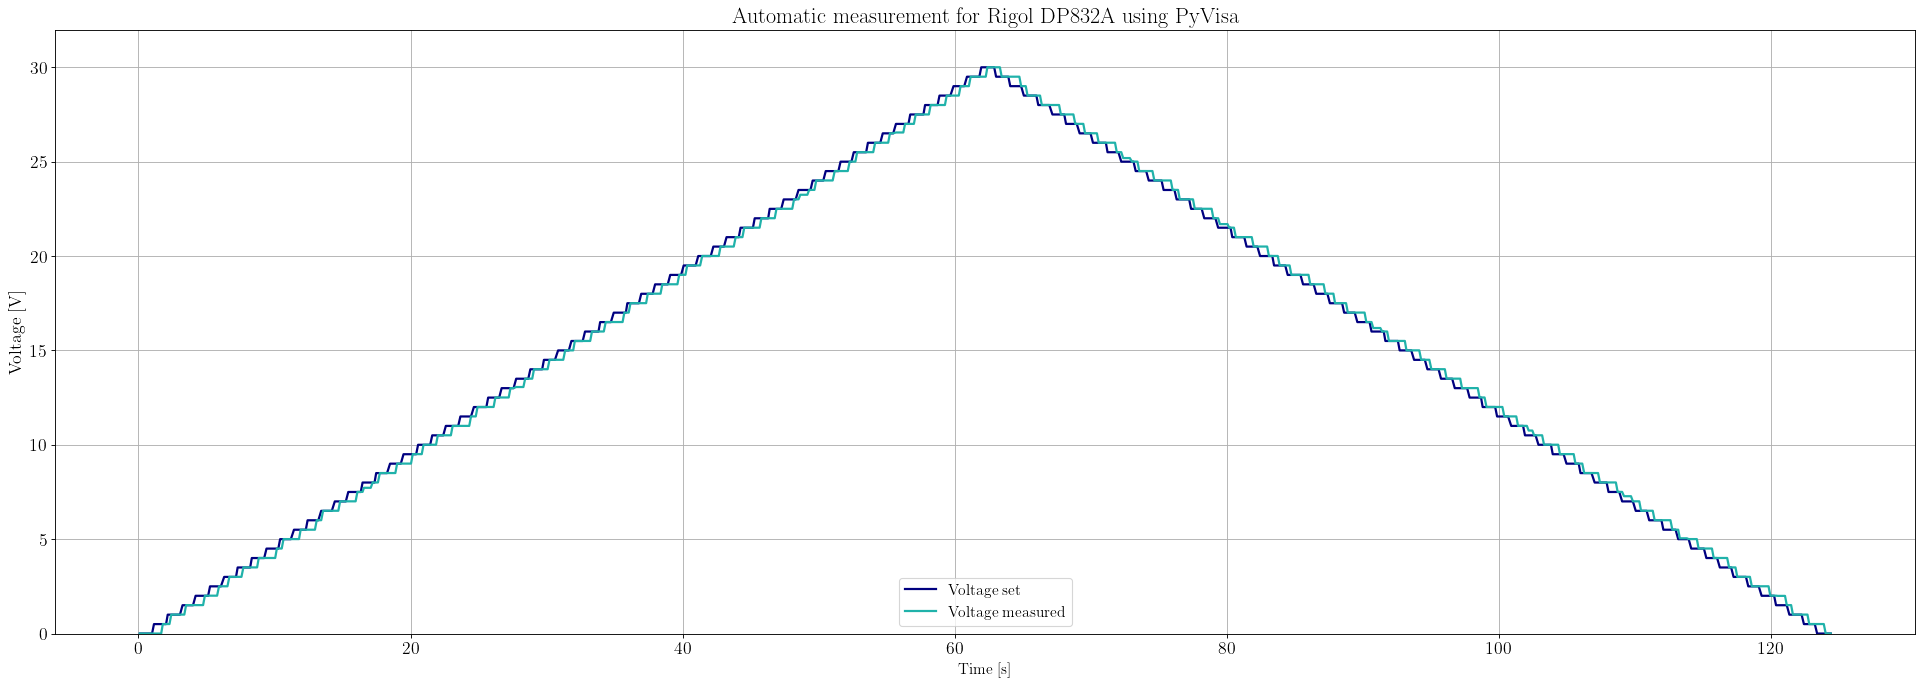

0

In [36]:
plot_measurement()